In [45]:
# =============================
# 🔥 PyTorch
# =============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# =============================
# 📊 data process
# =============================
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================
# 🧠 ML
# =============================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

# =============================
# 🖼️ OpenCV
# =============================
import cv2

In [46]:
# check device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps" if torch.backends.mps.is_available() else device)

print(device)

mps


In [47]:
# prepare dataset
trainDataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

testDataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Confirm they are in grayscale (they should already be).
# should be [1, 28, 28], 1 channel, 28x28 pixels (grayscale)
train_loader = torch.utils.data.DataLoader(
    trainDataset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    testDataset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

print(trainDataset[0][0].shape)
print(testDataset[0][1])

torch.Size([1, 28, 28])
9


In [48]:
# clean up the data
# go through the dataset and remove all the images that has different shape
shape = trainDataset[0][0].shape
print(f"shape: {shape}")
to_remove = []

for i in tqdm(range(len(trainDataset))):
    if trainDataset[i][0].shape != shape:
        to_remove.append(i)
print(f"removing {len(to_remove)} images from the training dataset")
        
for i in tqdm(range(len(testDataset))):
    if testDataset[i][0].shape != shape:
        to_remove.append(i)
print(f"removing {len(to_remove)} images from the test dataset")

shape: torch.Size([1, 28, 28])


100%|██████████| 60000/60000 [00:01<00:00, 46438.62it/s]


removing 0 images from the training dataset


100%|██████████| 10000/10000 [00:00<00:00, 46477.27it/s]

removing 0 images from the test dataset


In [49]:
def siftFeatureDetector(image):
    try:
        sift = cv2.SIFT_create()

        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype('uint8')
    
        _, descriptors = sift.detectAndCompute(image_np, None)

        if descriptors is None or descriptors.shape[0] == 0:
            return np.array([])
        return descriptors
    except:
        print(f"Error in SIFT, image shape: {image.shape}")
        return np.array([])

In [50]:
def extraDescriptorsAndLabel(data):
    descriptors = siftFeatureDetector(data[0])
    return descriptors, data[1]

In [51]:
def extraDescriptorsAndLabels(data_loader):
    all_descriptors = []
    all_labels = []

    # use tqdm to show progress bar
    for (data, labels) in tqdm(data_loader, desc="Processing Batches", unit="batch"):
        for item in zip(data, labels):
            descriptors, label = extraDescriptorsAndLabel(item)

            if len(descriptors) > 0:
                all_descriptors.append(descriptors)
                all_labels.append(label)

    # verify that the descriptors and the labels are being stored correctly
    if len(all_descriptors) == len(all_labels):
        all_descriptors = np.vstack(all_descriptors)
        return all_descriptors, all_labels
    else:
        print("Error: descriptors and labels are not the same length")
        return None

In [52]:
class Task1_MLP(nn.Module):
    def __init__(self, input_dim=76, hidden_dim=128, output_dim=10):
        super(Task1_MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [53]:
# task 1
# 1. SIFT Feature Extraction
#  1.1 Apply the SIFT feature detector to each image
print(trainDataset[12000][0].shape)
print("----------------")

train_descriptors, train_labels = extraDescriptorsAndLabels(train_loader)
test_descriptors, test_labels = extraDescriptorsAndLabels(test_loader)

torch.Size([1, 28, 28])
----------------


Processing Batches: 100%|██████████| 937/937 [00:21<00:00, 44.58batch/s]


In [54]:
#  1.2 Obtain a suitable representation of the SIFT descriptors as we learned in the class
# use the K-means clustering algorithm to cluster the descriptors
# convert the descriptors to visual words
valid_descriptors = [d for d in train_descriptors if d is not None and len(d) > 0]        
features = np.vstack(valid_descriptors)
print(f"trainnig feature shape: {features.shape}")  # (num_descriptors, 128)

trainnig feature shape: (241232, 128)


In [55]:
# this step is to determine the number of clusters, but it takes too long to run
# and cluster number is determined so we can skip this step
if 0:
    reduced_amount = 50000
    reduced_features = features[:reduced_amount]
    silhouette_scores = []
    k_values = range(100, 150)

    for k in tqdm(k_values, desc="calculate Inertia"):
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(reduced_features)
        score = silhouette_score(reduced_features, labels)
        silhouette_scores.append(score)

    # draw Silhouette Score curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o', color='orange')
    plt.xlabel('k_values')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. k_values')
    plt.grid(True)
    plt.show()
    # when cluster number is 116 the silhouette score is the highest

In [56]:
k_clusters = 116
k_means = KMeans(n_clusters=k_clusters, random_state=0)
k_means.fit(features)


KMeans(n_clusters=116, random_state=0)

In [57]:
sample_descriptors = np.array(valid_descriptors[0])
print(sample_descriptors)
test = k_means.predict(sample_descriptors.reshape(1, -1))
print(test)

[  0.   3.  10.   0.   0.   0.  46.   5.   5.  19.  17.   0.   0.   0.
 159.  23.   3.   4.   7.   2.   0.   3. 159.  26.   1.   5.  12.   2.
   0.  26. 159.   2.  14.  17.  33.   0.   0.   0.   5.   1. 159.  80.
  49.   0.   0.   1.  40.  49.  41.   7.  15.   6.   2.  47. 135.  39.
   8.  16.  26.   5.   1.  27. 129.  27.  35.   4.   0.   0.   0.   0.
   0.   0. 159.  34.   0.   0.   0.   0.   2.  15. 109.  10.   4.   5.
   3.  15.  31.  12.   0.   1.  19.   6.   2.  10.  48.   7.  16.   2.
   0.   0.   0.   0.   3.   3. 159.  69.   5.   0.   0.   0.   9.  20.
  69.  43.  62.  46.   2.   1.   3.   3.   3.  10.  91.  41.   1.   2.
  11.   9.]
[24]


In [58]:
def descriptors_to_vector(descriptors, kmeans_model, k_clusters):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(k_clusters)  # 如果描述符为空，返回全零向量

    features = []
    for d in descriptors:
        if d is None or len(d) == 0:
            continue
        for descriptor in d:
            features.append(d)

    cluster_labels = []
    for descriptor in descriptors:
        if descriptor is None or len(descriptor) == 0:
            continue
        cluster_labels.append(kmeans_model.predict(descriptor.reshape(1, -1)))
        
    histogram, _ = np.histogram(cluster_labels, bins=np.arange(k_clusters + 1))
    histogram = histogram / np.linalg.norm(histogram) if np.linalg.norm(histogram) != 0 else histogram
    
    return histogram

[0.        0.        0.        0.        0.        0.        0.
 0.        0.4472136 0.        0.        0.        0.        0.
 0.4472136 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.4472136 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.4472136 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.4472136 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.       

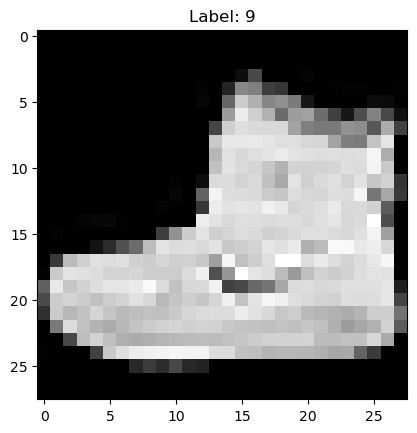

In [59]:
# print example train data
image = trainDataset[0][0].numpy().squeeze(0)
label = trainDataset[0][1]
plt.title(f"Label: {label}")
plt.imshow(image, cmap='gray')

descriptors = siftFeatureDetector(trainDataset[0][0])
vector = descriptors_to_vector(descriptors, k_means, k_clusters)
print(vector)

In [69]:
#  1.3 Document how you constructed the final feature vector (feature dimensionality, etc.).
train_vectors = []
train_labels = []
for (data, labels) in tqdm(train_loader, desc="Processing Batches", unit="batch"):
    for item in zip(data, labels):
            descriptors, label = extraDescriptorsAndLabel(item)

            train_labels.append(label)
            train_vectors.append(descriptors_to_vector(descriptors, k_means, k_clusters))

test_vectors = []
test_labels = []
for (data, labels) in tqdm(test_loader, desc="Processing Batches", unit="batch"):
    for item in zip(data, labels):
            descriptors, label = extraDescriptorsAndLabel(item)

            test_labels.append(label)
            test_vectors.append(descriptors_to_vector(descriptors, k_means, k_clusters))

# 2. MLP Training
#  2.1 MLP architecture: Use up to two hidden layers. Define the number of neurons in each layer (layer size).
#  2.2 Hyperparameter Tuning: See the next section for the list of hyperparameters to experiment with.
#  2.3 Train on the training set, evaluate on both training and testing sets.
# 3. Accuracy Reporting
#  3.1 Report and compare the training vs. testing accuracy for each experiment.

Processing Batches: 100%|██████████| 156/156 [00:08<00:00, 19.13batch/s]


In [73]:
def train(learning_rate, batch_size, optimizer, train_vectors, train_labels, test_vectors, test_labels):
    model = Task1_MLP(k_clusters)
    train_vectors = torch.tensor(train_vectors, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_vectors = torch.tensor(test_vectors, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    # hyperparameters
    num_epochs = 20
    optimizer = optimizer(model.parameters(), lr=learning_rate)

    train_dataset = TensorDataset(train_vectors, train_labels)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(test_vectors, test_labels)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # 损失记录
    train_losses = []
    test_losses = []

    # 训练和验证循环
    for epoch in tqdm(range(num_epochs), desc="Epoch", unit="epoch"):
        model.train()
        running_loss = 0.0

        # 训练阶段
        for batch_data, batch_labels in tqdm(train_loader, desc="Processing Batches", unit="batch", leave=False):
            batch_data, batch_labels = batch_data.to(
                device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_data.size(0)  # 加权求和损失

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data, batch_labels in train_loader:
                batch_data, batch_labels = batch_data.to(
                    device), batch_labels.to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item() * batch_data.size(0)

        avg_val_loss = val_loss / len(train_loader.dataset)
        test_losses.append(avg_val_loss)

    # 可视化损失
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # calculate accuracy RMSE
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_data, batch_labels in tqdm(test_loader, desc="Testing Batches", unit="batch", leave=False):
            batch_data, batch_labels = batch_data.to(
                device), batch_labels.to(device)
            outputs = model(batch_data)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")
    print(f"RMSE: {np.sqrt(np.mean(np.array(test_losses))):.4f}")
    print(f"RAE : {np.mean(np.array(test_losses)):.4f}")

Epoch: 100%|██████████| 20/20 [04:32<00:00, 13.65s/epoch]


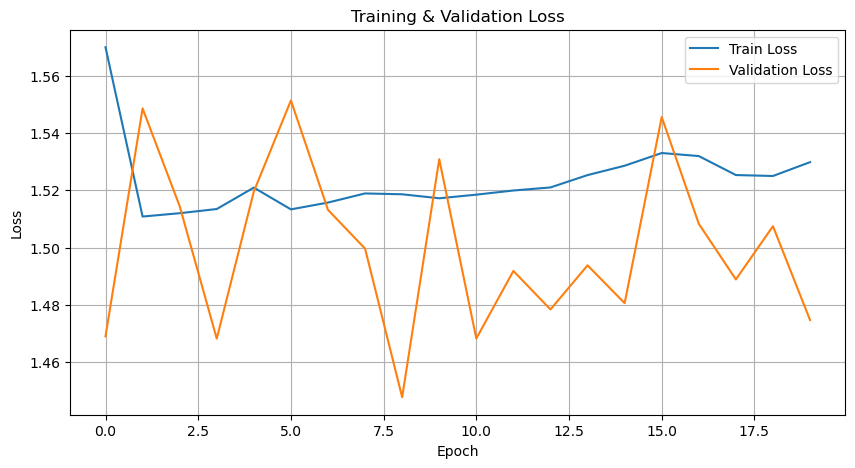

Accuracy: 46.92%
RMSE: 1.2248
RAE : 1.5000


Epoch: 100%|██████████| 20/20 [04:28<00:00, 13.45s/epoch]


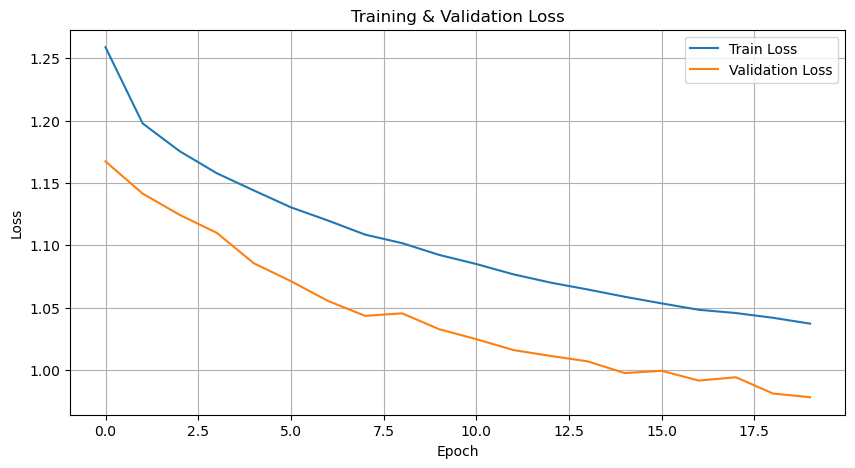

Accuracy: 55.96%
RMSE: 1.0216
RAE : 1.0438


Epoch: 100%|██████████| 20/20 [04:32<00:00, 13.61s/epoch]


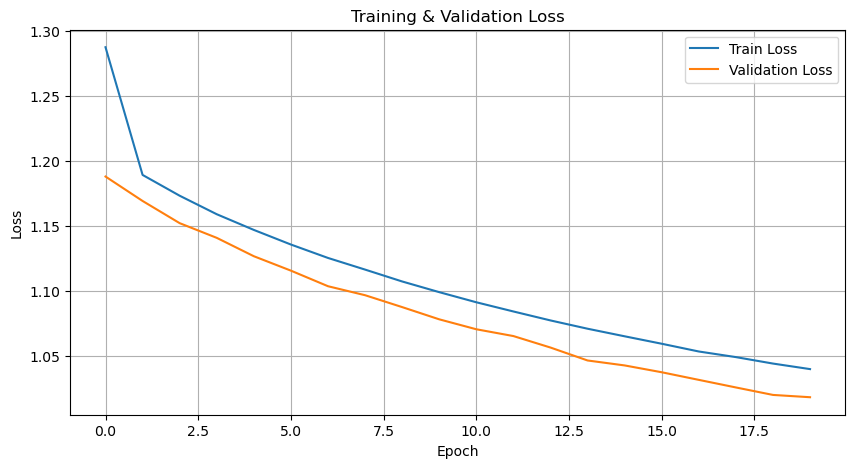

Accuracy: 58.55%
RMSE: 1.0409
RAE : 1.0834


Epoch: 100%|██████████| 20/20 [04:25<00:00, 13.26s/epoch]


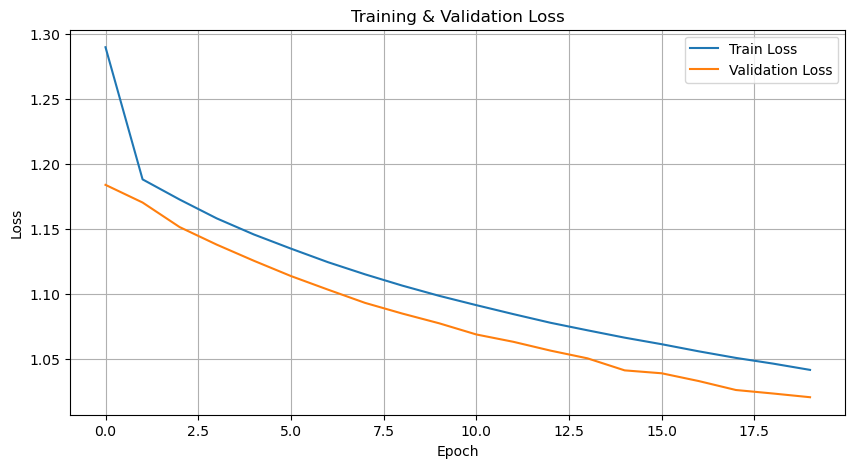

Accuracy: 58.74%
RMSE: 1.0408
RAE : 1.0833


In [75]:
# Combination A: Learning rate = 0.1, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RMSE 
train(0.1, 16, optim.Adam, train_vectors, train_labels, test_vectors, test_labels)
# Combination B: Learning rate = 0.01, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RMSE
train(0.01, 16, optim.Adam, train_vectors, train_labels, test_vectors, test_labels)
# Combination C: Learning rate = 0.001, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RMSE 
train(0.001, 16, optim.Adam, train_vectors, train_labels, test_vectors, test_labels)
# Combination D: Learning rate = 0.001, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RAE 
train(0.001, 16, optim.Adam, train_vectors, train_labels, test_vectors, test_labels)